# Day 02: Lines

For this category, I wanted to investigate the potential to create elevation contours for anywhere in the world.

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration
Dependency imports and utility functions are in a separate `plotter.py` file in order to keep these notebooks clean.

In [1]:
import os
import requests
from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects


import geopandas as gpd
import pandas as pd
import numpy as np
from osgeo import gdal
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Digital elevation model
Use the `elevation` package to read in [NASA SRTM 30m DEM data](https://lpdaac.usgs.gov/products/srtmgl1nv003/) within a certain bounding box. Simple instructions to visualize elevation contours from raster DEM models can be found [here](https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/).

In [2]:
# Choose bounding box
llcrnrlon=11.4
llcrnrlat=46.4
urcrnrlon=12.1
urcrnrlat=46.7
bbox = [llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat]

# Choose location name
location = "Dolomiti"

In [3]:
# # Choose bounding box
# llcrnrlon=86.85
# llcrnrlat=27.95
# urcrnrlon=87.0
# urcrnrlat=28.0
# bbox = [llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat]

# # Choose location name
# location = "Himalayas"

In [4]:
# Choose desired file name
filename = f"{location}-30m-DEM.tif"

# Download DEM file for that bounding box
!eio clip -o $filename --bounds $llcrnrlon $llcrnrlat $urcrnrlon $urcrnrlat

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.cc8f01353ebf4a36920f9da0c14365c2.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 11.4 46.7 12.1 46.4 SRTM1.cc8f01353ebf4a36920f9da0c14365c2.vrt /Users/npaul/GEM/30-day-map-challenge/notebooks/Dolomiti-30m-DEM.tif
rm -f SRTM1.cc8f01353ebf4a36920f9da0c14365c2.vrt


In [5]:
# Read the data and metadata
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# Convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

# Replace no data values
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan
    
# Find max elevation
max_elev = data_array.max()
print(f"Max elevation of data = {max_elev}")

Max elevation of data = 3309.0


# Query OSM for peak data using Overpass

In [7]:
# Arrange URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Arrange bounding box string
osm_bbox = [llcrnrlat, llcrnrlon, urcrnrlat, urcrnrlon]
bbox_str = ','.join([str(b) for b in osm_bbox])

# Construct query for peak data
overpass_query = '''
[out:json][timeout:25];
(
  node["natural"="peak"](''' + bbox_str + ''');
);
out body;
>;
out skel qt;
'''

# Query OSM
response = requests.get(overpass_url, params={'data': overpass_query})

# Parse data
data = response.json()

# Convert to dataframe
df = pd.DataFrame(data['elements'])

# Explode tags into columns
df = pd.concat([df, df['tags'].apply(pd.Series)], axis=1)

# Preview
print(df.columns)
df.head(5)

Index(['type', 'id', 'lat', 'lon', 'tags', 'ele', 'name', 'natural', 'name:de',
       'name:it', 'summit:cross', 'wikidata', 'wikipedia', 'man_made',
       'name:lld', 'prominence', 'alt_name', 'loc_ref', 'tourism', 'source',
       'summit:register', 'old_name', 'name:uk', 'source: prominence',
       'alt_name:lld', 'artist_name', 'historic', 'start_date', 'fixme',
       'loc_name', 'name:rm', 'alt_name:de', 'note', 'alt_name:it',
       'viewpoint'],
      dtype='object')


,type,id,lat,lon,tags,ele,name,natural,name:de,name:it,...,artist_name,historic,start_date,fixme,loc_name,name:rm,alt_name:de,note,alt_name:it,viewpoint
0,node,26862539,46.607744,12.044477,"{'ele': '2794', 'name': 'Bechei di Sopra', 'na...",2794,Bechei di Sopra,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,26862661,46.474089,11.643828,"{'ele': '3004', 'name': 'Kesselkogel - Catinac...",3004,Kesselkogel - Catinaccio d'Antermoia,peak,Kesselkogel,Catinaccio d'Antermoia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,26862684,46.479167,12.098056,"{'ele': '2715', 'man_made': 'survey_point', 'n...",2715,Cima Ambrizzola,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,26862898,46.612121,11.773639,"{'ele': '3025', 'name': 'La Furchёta', 'name:d...",3025,La Furchёta,peak,Furchetta,Furchetta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,26864376,46.551392,12.014163,"{'ele': '2989', 'name': 'Punta di mezzo di Fan...",2989,Punta di mezzo di Fanes,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Reduce to N values for column of interest
col = 'ele'
n = 15
df.ele = pd.to_numeric(df.ele) # bad sorting on ele column
peaks = df.sort_values(col, ascending=False).head(n)

# Preview
peaks

,type,id,lat,lon,tags,ele,name,natural,name:de,name:it,...,artist_name,historic,start_date,fixme,loc_name,name:rm,alt_name:de,note,alt_name:it,viewpoint
53,node,534251275,46.434526,11.851326,"{'ele': '3343', 'name': 'Punta Penia', 'name:l...",3343.0,Punta Penia,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,node,3060885640,46.434377,11.856468,"{'ele': '3310', 'name': 'Punta Rocca', 'natura...",3310.0,Punta Rocca,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,node,26864932,46.551012,12.065500,"{'ele': '3244', 'name': 'Tofana di Mezzo', 'na...",3244.0,Tofana di Mezzo,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,node,894092771,46.557203,12.064367,"{'alt_name': 'Tofana Terza', 'ele': '3238', 'l...",3238.0,Tofana di Dentro,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,Tofana de Inze,NaN,NaN,NaN,NaN,NaN
7,node,26864933,46.537008,12.051053,"{'ele': '3225', 'name': 'Tofana di Rozes', 'na...",3225.0,Tofana di Rozes,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,node,2606944989,46.442286,11.831992,"{'ele': '3210', 'name': 'Gran Vernel', 'natura...",3210.0,Gran Vernel,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node,26864543,46.524926,11.735160,"{'ele': '3181', 'name': 'Saslonch - Langkofel ...",3181.0,Saslonch - Langkofel - Sassolungo,peak,Langkofel,Sassolungo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,node,526109415,46.508835,11.828278,"{'ele': '3152', 'name': 'Piz Boè', 'natural': ...",3152.0,Piz Boè,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,node,3742421761,46.510438,11.733315,"{'ele': '3126', 'name': 'Punta Grohmann - Groh...",3126.0,Punta Grohmann - Grohmannspitze,peak,Grohmannspitze,Punta Grohmann,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,node,2606944998,46.439699,11.833824,"{'ele': '3098', 'name': 'Piccolo Vernel', 'nat...",3098.0,Piccolo Vernel,peak,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Construct map

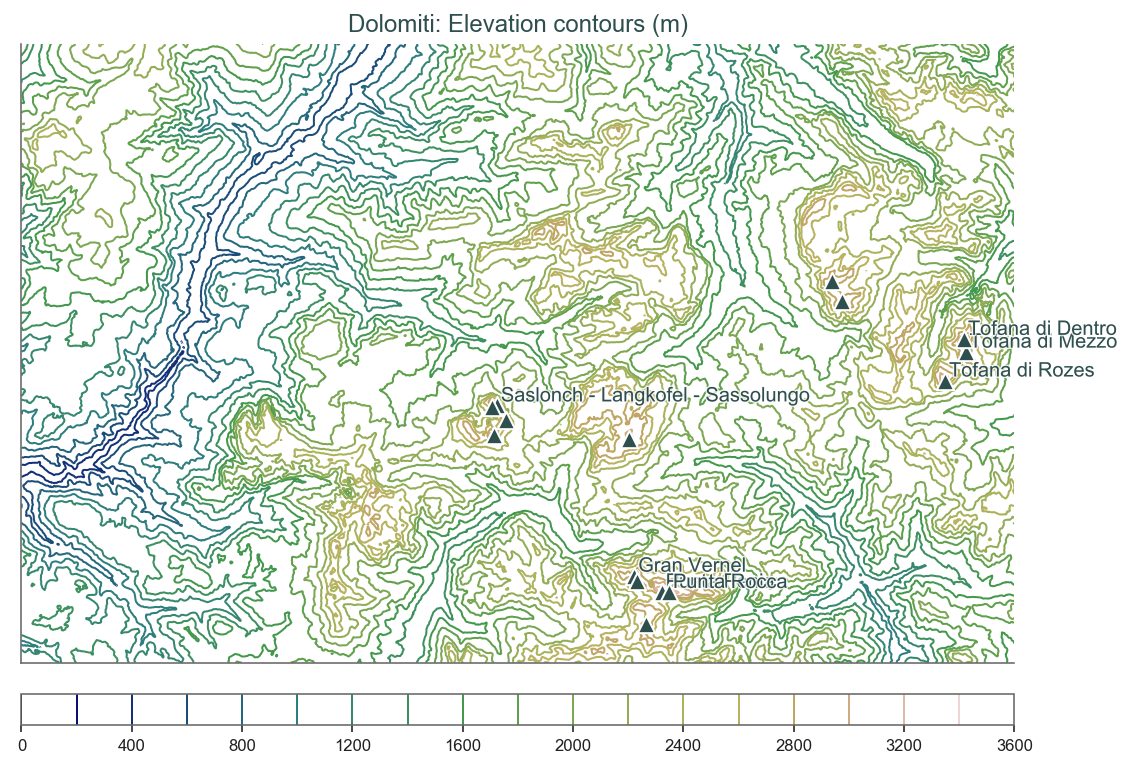

In [15]:
# Construct figure
fig = plt.figure(figsize=(8,6))

# Create basemap
m = Basemap(projection='merc',
            llcrnrlat=llcrnrlat,
            urcrnrlat=urcrnrlat,
            llcrnrlon=llcrnrlon,
            urcrnrlon=urcrnrlon,
            resolution='c')

# Project data coordinates to map
datain = np.flipud(data_array)
ny, nx = datain.shape
lons,lats = m.makegrid(nx,ny) 
x,y = m(lons,lats)

# Choose contour levels for plot
min_plot_elev, max_plot_elev, step_plot_elev = 0, 3800, 200
# min_plot_elev, max_plot_elev, step_plot_elev = 4000, 9000, 200
levels = list(range(min_plot_elev, max_plot_elev, step_plot_elev))

# Add contours and colorbar
cntr = m.contour(x, y, datain, levels, cmap=plt.cm.gist_earth, linewidths=1)
cbar = m.colorbar(cntr, location='bottom', pad='5%')

# Add peak markers
xx,yy = m(peaks.lon.values, peaks.lat.values)
pnts = m.scatter(xx, yy, c='DarkSlateGray', marker="^", edgecolors="w", s=75, zorder=50)

# Add peak labels
# m = 3 # cap annotation labels
m = 7 # cap annotation labels
for i, row in peaks.head(m).reset_index().iterrows():
    name = row['name']
    try:
        name = row['name:en']
    except:
        pass
    if name != name:
        name = row['name']
        if name != name:
            name = ""
    plt.annotate(name, xy=(xx[i],yy[i]), color="DarkSlateGray",
                 xytext=(2, 2), textcoords="offset points",
                 path_effects=[
                                PathEffects.withStroke(
                                                        linewidth=1.5,
                                                        foreground="w",
                                                        alpha=0.8
                        )]
)

# Additional details - Not used here, but could be useful in the future
# cstl = m.drawcoastlines(linewidth=.5, color='DarkSlateGray')
# cont = m.fillcontinents(color='w', lake_color='DarkSlateGray')
# lsmk = m.drawlsmask(land_color='w', ocean_color='DarkSlateGray', lakes=True)
# srlf = m.shadedrelief()
# cadm = m.drawcountries(linewidth=.5, color='DarkSlateGray')
# rvrs = m.drawrivers(linewidth=.5, color='DarkSlateGray')
# meri = m.drawmeridians(np.arange(0,360,60), linewidth=.2, labels=[1,0,0,1], labelstyle='+/-', color='Silver' ) 
# para = m.drawparallels(np.arange(-90,90,30), linewidth=.2, labels=[1,0,0,1], labelstyle='+/-', color='Silver')
# boun = m.drawmapboundary(linewidth=0.5, color='DarkSlateGray')

# Tight layout
plt.title(f"{location.title()}: Elevation contours (m)", color="DarkSlateGray")
plt.tight_layout()

# Save map
out_folder = os.path.join("..", "contributions")
out_path = os.path.join(out_folder, f"02_{location.title()}.png")
fig.savefig(out_path, dpi=300, facecolor="w")